# Derivatives Analytics - Objects Composition

**Author**: [Gabriele Pompa](https://www.linkedin.com/in/gabrielepompa/): gabriele.pompa@unisi.com

# Table of contents

[Executive Summary](#executive-summary)

**TODO**

### **Resources**: 

- [_Python for Finance (2nd ed.)_](http://shop.oreilly.com/product/0636920117728.do): Chapter 6 Object-Oriented Programming.


- [Object-Oriented Programming in Python](https://python-textbok.readthedocs.io/en/1.0/index.html): From [Errors and exceptions](https://python-textbok.readthedocs.io/en/1.0/Errors_and_Exceptions.html): Errors and Handling exceptions sections. From [Functions](https://python-textbok.readthedocs.io/en/1.0/Functions.html): up to `*args` and `**kwargs` section. Section [Object-oriented programming](https://python-textbok.readthedocs.io/en/1.0/Object_Oriented_Programming.html)

# Executive Summary <a name="executive-summary"></a>

**TODO**

The following sections are organized as follows:

**TODO**

These are the basic imports

In [1]:
# for NumPy arrays
import numpy as np

# for Pandas Series and DataFrame
import pandas as pd

# for statistical functions
from scipy import stats

# for Matplotlib plotting
import matplotlib.pyplot as plt

# to do inline plots in the Notebook
%matplotlib inline

# for Operating System operations
import os

# for some mathematical functions
import math

# for date management
import datetime as dt

# to identify iterable data-structures
from collections.abc import Iterable

In [2]:
def datetime_obj_to_date_string(date):
    """
    Utility function to convert: from dt.datetime object --> to 'dd-mm-YYYY' String
    """
    return date.strftime("%d-%m-%Y") if isinstance(date, dt.datetime) else date

In [3]:
def test_valid_format(date_string, date_format="%d-%m-%Y"):
    """
    Utility function to test whether a date_string String in input is conform to date_format (default: 'dd-mm-YYYY') date format.
    If not raises an error.
    """
    try:
        dt.datetime.strptime(date_string, date_format)
    except ValueError:
        print("String '{}' in input is not conform to 'dd-mm-YYYY' date format".format(date_string))
        raise
    else:
        return True

In [4]:
def date_string_to_datetime_obj(date_string):
    """
    Utility function to convert: from 'dd-mm-YYYY' String object --> to dt.datetime.
    ValueError, due to wrong date format of the input String, is controlled.
    """
    
    return dt.datetime.strptime(date_string, "%d-%m-%Y") if (isinstance(date_string, str) and test_valid_format(date_string)) \
                                                         else date_string

In [5]:
def is_iterable(x):
    """
    Utility function to check if input can be iterated over (that is, if input is a List, np.array, pd.date_range, etc.).
    """    
    return isinstance(x, Iterable)

In [6]:
def is_iterable_not_string(x):
    """
    Utility function to check if input can be iterated over (that is, if input is a List, np.array, pd.date_range, etc.)
    but it is not a String
    """
    return is_iterable(x) and not isinstance(x, str)

In [7]:
def is_numeric(x):
    """
    Utility function to check if input is/contains numeric data.
    """
    
    if is_iterable_not_string(x):
        return isinstance(x[0], float) or isinstance(x[0], int)
    else:
        return isinstance(x, float) or isinstance(x, int)

In [8]:
def is_date(x):
    """
    Utility function to check if input is/contains date-like data.
    The error due to invalid (non 'dd-mm-YYYY') date Strings is controlled thanks to test_valid_format() function.
    """
    
    if is_iterable_not_string(x):
        return isinstance(x[0], dt.datetime) or (isinstance(x[0], str) and test_valid_format(x[0]))
    else:
        return isinstance(x, dt.datetime) or (isinstance(x, str) and test_valid_format(x))

In [9]:
class MarketEnvironment:
    """
    MarketEnvironment class: setting the market environment: date, underlying level, volatility level and short-rate.
    
    Attributes:
    -----------
        t (str; dt.datetime):     valuation date. Can be either a "dd-mm-YYYY" String or a dt.datetime object
        r (float):                continuously compounded short-rate;
        S_t (float):              spot price of the underlying asset at the valuation date 't';
        sigma (float):            volatility of underlying asset;
    
    Public Methods:
    --------   
    
        getters and setters for all attributes
        
    Usage: 
    --------   
        - default: MarketEnvironment() is equivalent to 
                   MarketEnvironment(t="19-04-2020", r=0.05, S_t=90.0, sigma=0.2)

        - general: MarketEnvironment(t="DD-MM-YYYY" String, r=Float, S_t=Float, sigma=Float)
    """
    
    def __init__(self, t="19-04-2020", r=0.05, S_t=90.0, sigma=0.2):
        
        print("Initializing the MarketEnvironment!")
        
        self.__t     = date_string_to_datetime_obj(t)
        self.__r     = r
        self.__S     = S_t
        self.__sigma = sigma
        
    def __repr__(self):
        return r"MarketEnvironment(t={}, r={:.1f}%, S_t={:.1f}, sigma={:.1f}%)".\
               format(self.get_t().strftime("%d-%m-%Y"), self.get_r()*100, self.get_S(), self.get_sigma()*100)

    # getters
    def get_t(self):
        return self.__t

    def get_r(self):
        return self.__r

    def get_S(self):
        return self.__S
    
    def get_sigma(self):
        return self.__sigma
    
    # setters 
    def set_t(self, t):
        self.__t = date_string_to_datetime_obj(t)

    def set_r(self, r):
        self.__r = r

    def set_S(self, S):
        self.__S = S
        
    def set_sigma(self, sigma):
        self.__sigma = sigma

In [10]:
class EuropeanOption:
    """
    EuropeanOption abstract class: an interface setting the template for any option with european-style exercise.
    It uses a MarketEnvironment object to define the current market conditions under which the option is modeled. 
    This class is not meant to be instantiated.
    
    Attributes:
    -----------
        mkt_env (MarketEnvironment): Instance of MarketEnvironment class
        type (str):                  Optional. Type of the option. Can be either 'call' or 'put';
        S_t (float):                 'S' attribute of mkt_env.
        K (float):                   Optional. Strike price;
        t (str; dt.datetime):        't' attribute of mkt_env.
        T (str; dt.datetime):        Optional. Expiration date. Can be either a "dd-mm-YYYY" String or a dt.datetime object
        tau (float):                 time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                   'r' attribute of mkt_env.
        sigma (float):               'sigma' attribute of mkt_env.

    Public Methods:
    --------
    
        time_to_maturity: float
            Computes the time-to-maturity of the option.
        
        parse_S_tau_parameters: float
            Parses underlying and time parameters, discribinating between time-to-maturity and valuation date
            time parameter.
    
        d1_and_d2: flaot, float
            Computes the d1 and d2 terms of Black-Scholes pricing formula

        PnL: float
            Computes the P&L of the option.

    Template Methods:
    --------   
    
        getters for all common attributes
        
        setters for common attributes, not belonging to mkt_env
        
        payoff: float
            Template method for payoff. Raises NotImplementedError if called.

        price_upper_limit: float 
            Template method for upper limit. Raises NotImplementedError if called.

        price_lower_limit: float 
            Template method for lower limit. Raises NotImplementedError if called.
            
        price: float
            Template method for price. Raises NotImplementedError if called.

    """

    def __init__(self, mkt_env, option_type='call', K=100.0, T="31-12-2020"):
        
        print("Initializing the EuropeanOption!")

        # option type check
        if option_type not in ['call', 'put']:
            raise NotImplementedError("Option Type: '{}' does not exist!".format(option_type))
        
        self.__type  = option_type
        self.__S     = mkt_env.get_S()
        self.__K     = K
        self.__t     = mkt_env.get_t()
        self.__T     = date_string_to_datetime_obj(T)
        self.__tau   = self.time_to_maturity()
        self.__r     = mkt_env.get_r()
        self.__sigma = mkt_env.get_sigma()
        
        # default d1 and d2 terms
        self.__d1, self.__d2 = self.d1_and_d2(S=self.get_S(), tau=self.get_tau())
        
        # empty initial price of the option
        self.__initial_price = None
               
        # empty informations dictionary
        self.__docstring_dict = {}        
        
    # string representation method template
    def __repr__(self):
        raise NotImplementedError()
    
    # getters
    def get_type(self):
        return self.__type

    def get_S(self):
        return self.__S
    
    def get_sigma(self):
        return self.__sigma
    
    def get_K(self):
        return self.__K
    
    def get_t(self):
        return self.__t

    def get_T(self):
        return self.__T

    def get_tau(self):
        return self.__tau

    def get_r(self):
        return self.__r
    
    def get_sigma(self):
        return self.__sigma
    
    def get_d1_and_d2(self):
        return self.__d1, self.__d2
    
    def get_initial_price(self):
        return NotImplementedError()
    
    # doctring getter template
    def get_docstring(self, label):
        raise NotImplementedError()

    # setters
    def set_type(self, option_type):
        self.__type = option_type
        
        # option type check
        if option_type not in ['call', 'put']:
            raise NotImplementedError("Option Type: '{}' does not exist!".format(option_type))
            
    def set_K(self, K):
        self.__K = K
    
    def set_T(self, T):
        self.__T = date_string_to_datetime_obj(T)
        # update time to maturity, given changed T, to keep internal consistency
        self.__update_tau() 
    
    def set_tau(self, tau):
        self.__tau = tau
        # update expiration date, given changed tau, to keep internal consistency
        self.__update_T()
        
    # update methods (private)
    def __update_tau(self):
        self.__tau = self.time_to_maturity()

    def __update_T(self):
        self.__T = self.__t + dt.timedelta(days=math.ceil(self.__tau*365))

    # utility methods
    def time_to_maturity(self, *args, **kwargs):
        """
        Utility method to compute time-to-maturity
        """
        
        # parsing optional parameters
        t = args[0] if len(args) > 0 else kwargs['t'] if 't' in kwargs else self.get_t()
        T = args[1] if len(args) > 1 else kwargs['T'] if 'T' in kwargs else self.get_T()
        
        # convert to dt.datetime objects, if needed
        t = date_string_to_datetime_obj(t)
        T = date_string_to_datetime_obj(T)
        
        # compute and return time to maturity (in years)
        return (T-t).days / 365.0
    
    def parse_S_tau_parameters(self, *args, **kwargs):
        """
        Utility method to parse underlying and time-parameters
        """

        # underlying value 
        S = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_S()

        # time parameter:
        time_param = args[1] if len(args) > 1 \
                     else kwargs['tau'] if 'tau' in kwargs \
                        else (kwargs['t'] if 't' in kwargs else None)
        
        # check that no multiple time parameters in input
        if is_iterable_not_string(time_param):
            raise NotImplementedError("No multiple time parameters allowed: {} given in input.".format(time_param))

        # time parameter interpretation according to its type        
        # case 1: no time-parameter in input
        if time_param is None:
            tau = self.get_tau()
        # case 2: valid time-to-maturity in input
        elif is_numeric(time_param):
            tau = time_param
        # case 3: valuation date in input, to be converted into time-to-maturity
        elif is_date(time_param):
            valuation_date = date_string_to_datetime_obj(time_param)
            tau = self.time_to_maturity(t=valuation_date)
        # error case: the time parameter in input has a data-type that is not recognized
        else: 
            raise TypeError("Type {} of input time parameter not recognized".format(type(time_param)))

        return S, tau
    
    # d1 and d2 terms
    def d1_and_d2(self,  *args, **kwargs):
        """
        Utility method to compute d1 and d2 terms of Black-Scholes pricing formula
        """
        
        # parsing optional parameters
        S     = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else None
        tau   = args[1] if len(args) > 1 else kwargs['tau'] if 'tau' in kwargs else None
        
        if (S is None) and (tau is None):
            return self.get_d1_and_d2()
        else:
            K     = args[2] if len(args) > 2 else kwargs['K'] if 'K' in kwargs else self.get_K()
            r     = args[3] if len(args) > 3 else kwargs['r'] if 'r' in kwargs else self.get_r()
            sigma = args[4] if len(args) > 4 else kwargs['sigma'] if 'sigma' in kwargs else self.get_sigma()
    
            # compute d1 and d2
            d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
            d2 = d1 - sigma * np.sqrt(tau)

            return d1, d2
    
    # payoff template
    def payoff(self):
        raise NotImplementedError()     
        
    # upper price limit template
    def price_upper_limit(self):
        raise NotImplementedError()     

    # lower price limit template
    def price_lower_limit(self):
        raise NotImplementedError()     
        
    # price template
    def price(self):
        raise NotImplementedError()
        
    # profit and loss calculation calculation - with optional *args and **kwargs parameters
    def PnL(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A valuation date (e.g. t='15-05-2020'): either a 'dd-mm-YYYY' String or a dt.datetime object
            - A time-to-maturity value (e.g. tau=0.5)
        """
        
        # underlying value and time-to-maturity
        S, tau = self.parse_S_tau_parameters(*args, **kwargs)
        
        # if tau==0, this is the P&L at option's expiration, that is the PnL if the option is kept until maturity
        if tau == 0.0:
            # P&L = payoff - initial price
            return self.payoff(S) - self.get_initial_price()
        
        # if tau > 0, this is the P&L as if the option position is closed before maturity, when the time-to-maturity is tau
        else:
            # P&L = current price - initial price
            return self.price(S, tau) - self.get_initial_price()

In [11]:
class PlainVanillaOption(EuropeanOption):
    """
    PlainVanillaOption class implementing payoff and pricing of plain-vanilla call and put options.
    Inherits from EuropeanOption base-class. Put price is calculated using put-call parity
    
    Attributes:
    -----------
        mkt_env (MarketEnvironment): Instance of MarketEnvironment class
        type (str):                  From 'type' attribute of EuropeanOption base class.
        S_t (float):                 'S' attribute of mkt_env.
        K (float):                   From 'K' attribute of EuropeanOption base class.
        t (str; dt.datetime):        't' attribute of mkt_env.
        T (str; dt.datetime):        From 'T' attribute of EuropeanOption base class.
        tau (float):                 time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                   'r' attribute of mkt_env.
        sigma (float):               'sigma' attribute of mkt_env.
    
    Public Methods:
    --------   

        public methods inherited from EuropeanOption class

        payoff: float
            Overridden method. Computes the payoff of the option and returns it

        price_upper_limit: float 
            Overridden method. Returns the upper limit for a vanilla option price.

        price_lower_limit: float 
            Overridden method. Returns the lower limit for a vanilla option price.
            
        price: float
            Overridden method. Computes the exact price of the option and returns it
            
    Usage: 
    --------   
        - default: PlainVanillaOption(mkt_env) is equivalent to 
                   PlainVanillaOption(mkt_env, option_type='call', K=100.0, T="31-12-2020")

        - general: PlainVanillaOption(mkt_env, option_type='call' or 'put' String, K=Float, T="DD-MM-YYYY" String)

    where: mkt_env is a MarketEnvironment instance.
    """
    
    # initializer with optional *args and **kwargs parameters
    def __init__(self, *args, **kwargs):  
        
        # calling the EuropeanOption initializer
        super(PlainVanillaOption, self).__init__(*args, **kwargs)
        
        # info strings
        self.__info = r"Plain Vanilla {} [K={:.1f}, T={} (tau={:.2f}y)]".format(self.get_type(), self.get_K(), datetime_obj_to_date_string(self.get_T()), self.get_tau())
        self.__mkt_info = r"[S_t={:.1f}, r={:.1f}%, sigma={:.1f}%, t={}]".format(self.get_S(), self.get_r()*100, self.get_sigma()*100, datetime_obj_to_date_string(self.get_t()))
        
        # initial price of the option
        self.__initial_price = self.price()
        
        # informations dictionary
        self.__docstring_dict = {
            'call':{
                'price_upper_limit': r"Upper limit: $S_t$",
                'payoff':            r"Payoff: $max(S-K, 0)$",
                'price_lower_limit': r"Lower limit: $max(S_t - K e^{-r \tau}, 0)$"
            },
            'put': {
                'price_upper_limit': r"Upper limit: $K e^{-r \tau}$",
                'payoff':            r"Payoff: $max(K-S, 0)$",
                'price_lower_limit': r"Lower limit: $max(K e^{-r \tau} - S_t, 0)$"}
        }
                
    def __repr__(self):
        return r"PlainVanillaOption('{}', S_t={:.1f}, K={:.1f}, t={}, T={}, tau={:.2f}y, r={:.1f}%, sigma={:.1f}%)".\
                format(self.get_type(), self.get_S(), self.get_K(), self.get_t().strftime("%d-%m-%Y"), 
                       self.get_T().strftime("%d-%m-%Y"), self.get_tau(), self.get_r()*100, self.get_sigma()*100)
    
    # getters
    def get_info(self):
        return self.__info
    
    def get_mkt_info(self):
        return self.__mkt_info
    
    def get_initial_price(self):
        return self.__initial_price

    def get_docstring(self, label):
        return self.__docstring_dict[self.get_type()][label] 
    
    # payoff calculation - with optional *args and **kwargs parameters
    def payoff(self, *args, **kwargs):
        """
        Can be called using (underlying), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
        """
        
        # underlying value
        S, _ = self.parse_S_tau_parameters(*args, **kwargs)
                
        # call case
        if self.get_type() == 'call':
            return self.__call_payoff(S)
        # put case
        else:
            return self.__put_payoff(S)
    
    def __call_payoff(self, S):
        if is_iterable(S):
            return np.array([max(0.0, s - self.get_K()) for s in S])
        else:
            return max(0.0, S - self.get_K())

    def __put_payoff(self, S):
        if is_iterable(S):
            return np.array([max(0.0, self.get_K() - s) for s in S])
        else:
            return max(0.0, self.get_K() - S)
        
    # upper price limit - with optional *args and **kwargs parameters
    def price_upper_limit(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A valuation date (e.g. t='15-05-2020'): either a 'dd-mm-YYYY' String or a dt.datetime object
            - A time-to-maturity value (e.g. tau=0.5)
        """

        # underlying value and time-to-maturity
        S, tau = self.parse_S_tau_parameters(*args, **kwargs)
                        
        # call case
        if self.get_type() == 'call':
            return S
        # put case
        else:
            return self.__put_price_upper_limit(S, tau)
    
    def __put_price_upper_limit(self, S, tau):
        if is_iterable(S):
            return np.repeat(self.get_K()*np.exp(-self.get_r() * tau), repeats=len(S)) 
        else:
            return self.get_K()*np.exp(-self.get_r() * tau)

    # lower price limit - with optional *args and **kwargs parameters
    def price_lower_limit(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A valuation date (e.g. t='15-05-2020'): either a 'dd-mm-YYYY' String or a dt.datetime object
            - A time-to-maturity value (e.g. tau=0.5)
        """

        # underlying value and time-to-maturity
        S, tau = self.parse_S_tau_parameters(*args, **kwargs)
                                       
        # call case
        if self.get_type() == 'call':
            return self.__call_price_lower_limit(S, tau)
        # put case
        else:
            return self.__put_price_lower_limit(S, tau)

    def __call_price_lower_limit(self, S, tau):
        if is_iterable(S):
            return np.array([max(s - self.get_K()*np.exp(-self.get_r() * tau), 0.0) for s in S])
        else:
            return max(S - self.get_K()*np.exp(-self.get_r() * tau), 0.0)
                                       
    def __put_price_lower_limit(self, S, tau):
        if is_iterable(S):
            return np.array([max(self.get_K()*np.exp(-self.get_r() * tau) - s, 0.0) for s in S])
        else:
            return max(self.get_K()*np.exp(-self.get_r() * tau) - S, 0.0)
                                       
    # price calculation - with optional *args and **kwargs parameters
    def price(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A valuation date (e.g. t='15-05-2020'): either a 'dd-mm-YYYY' String or a dt.datetime object
            - A time-to-maturity value (e.g. tau=0.5)
        """
                       
        # underlying value and time-to-maturity
        S, tau = self.parse_S_tau_parameters(*args, **kwargs)
               
        # call case
        if self.get_type() == 'call':
            return np.array([self.__call_price(s, tau) for s in S]) if is_iterable(S) else self.__call_price(S, tau)
        # put case
        else:
            return np.array([self.__put_price(s, tau) for s in S]) if is_iterable(S) else self.__put_price(S, tau)
          
    def __call_price(self, S, tau):
        
        if S == 0: # this is to avoid log(0) issues
            return 0.0
        elif tau == 0.0: # this is to avoid 0/0 issues
            return self.__call_payoff(S)
        else:
            K     = self.get_K()
            r     = self.get_r()
            
            # get d1 and d2 terms
            d1, d2 = self.d1_and_d2(S, tau)

            price = S * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * tau) * stats.norm.cdf(d2, 0.0, 1.0)

            return price
    
    def __put_price(self, S, tau):
        """ Put price from Put-Call parity relation: Call + Ke^{-r*tau} = Put + S"""
        return self.__call_price(S, tau) + self.get_K() * np.exp(- self.get_r() * tau) - S     

In [12]:
class DigitalOption(EuropeanOption):
    """
    DigitalOption class implementing payoff and pricing of digital call and put options.
    Inherits from EuropeanOption base-class. Put price is calculated using put-call parity
    
    Attributes:
    -----------
        mkt_env (MarketEnvironment): Instance of MarketEnvironment class
        Q (float):                   cash amount
        type (str):                  From 'type' attribute of EuropeanOption base class.
        S_t (float):                 'S' attribute of mkt_env.
        K (float):                   From 'K' attribute of EuropeanOption base class.
        t (str; dt.datetime):        't' attribute of mkt_env.
        T (str; dt.datetime):        From 'T' attribute of EuropeanOption base class.
        tau (float):                 time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                   'r' attribute of mkt_env.
        sigma (float):               'sigma' attribute of mkt_env.
    
    Public Methods:
    --------   
 
        public methods inherited from EuropeanOption class

        payoff: float
            Overridden method. Computes the payoff of the option and returns it

        price_upper_limit: float 
            Overridden method. Returns the upper limit for a vanilla option price.

        price_lower_limit: float 
            Overridden method. Returns the lower limit for a vanilla option price.
            
        price: float
            Overridden method. Computes the exact price of the option and returns it, using call_price() or put_price()

    Usage: 
    --------   
        - default: DigitalOption(mkt_env) is equivalent to 
                   DigitalOption(mkt_env, cash_amount=1.0, option_type='call', K=100.0, T="31-12-2020")

        - general: DigitalOption(mkt_env, cash_amount=Float, option_type='call' or 'put' String, K=Float, T="DD-MM-YYYY" String)

    where: mkt_env is a MarketEnvironment instance.
    """

    # initializer with optional *args and **kwargs parameters and default cash_amount
    # default keyword arguments (like cash_amount here) must go after args list argument in function def
    def __init__(self, *args, cash_amount=1.0, **kwargs):  
        
        # calling the EuropeanOption initializer
        super(DigitalOption, self).__init__(*args, **kwargs)
        
        # amount of cash in case of payment
        self.__Q = cash_amount    
        
        # info strings
        self.__info = r"CON {} [K={:.1f}, T={} (tau={:.2f}y), Q={:.1f}]".format(self.get_type(), self.get_K(), datetime_obj_to_date_string(self.get_T()), self.get_tau(), self.get_Q())
        self.__mkt_info = r"[S_t={:.1f}, r={:.1f}%, sigma={:.1f}%, t={}]".format(self.get_S(), self.get_r()*100, self.get_sigma()*100, datetime_obj_to_date_string(self.get_t()))
        
        # initial price of the option
        self.__initial_price = self.price()

        # informations dictionary
        self.__docstring_dict = {
            'call':{
                'price_upper_limit': r"Upper limit: $Q e^{-r \tau}$",
                'payoff':            r"Payoff: $Q$ $I(S > K)$",
                'price_lower_limit': r"Lower limit: $0$"
            },
            'put': {
                'price_upper_limit': r"Upper limit: $Q e^{-r \tau}$",
                'payoff':            r"Payoff: $Q$ $I(S \leq K)$",
                'price_lower_limit': r"Lower limit: $0$"}
        }        
                
    def __repr__(self):
        return r"DigitalOption('{}', cash={:.1f}, S_t={:.1f}, K={:.1f}, t={}, T={}, tau={:.2f}y, r={:.1f}%, sigma={:.1f}%)".\
                format(self.get_type(), self.get_Q(), self.get_S(), self.get_K(), self.get_t().strftime("%d-%m-%Y"), 
                       self.get_T().strftime("%d-%m-%Y"), self.get_tau(), self.get_r()*100, self.get_sigma()*100)
    
    # getters
    def get_info(self):
        return self.__info
    
    def get_mkt_info(self):
        return self.__mkt_info
    
    def get_Q(self):
        return self.__Q
    
    def get_initial_price(self):
        return self.__initial_price
    
    # docstring getter
    def get_docstring(self, label):
        return self.__docstring_dict[self.get_type()][label] 
    
    # setters
    def set_Q(self, cash_amount):
        self.__Q = cash_amount
    
    # payoff calculation - with optional *args and **kwargs parameters
    def payoff(self, *args, **kwargs):
        """
        Can be called using (underlying), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
        """
        
        # underlying value
        S, _ = self.parse_S_tau_parameters(*args, **kwargs)
        
        # call case
        if self.get_type() == 'call':
            return self.__call_payoff(S)
        # put case
        else:
            return self.__put_payoff(S)

    def __call_payoff(self, S):
        if is_iterable(S):
            return np.array([self.get_Q() * int(s > self.get_K()) for s in S])
        else:
            return self.get_Q() * int(S > self.get_K())

    def __put_payoff(self, S):
        if is_iterable(S):
            return np.array([self.get_Q() * int(s <= self.get_K()) for s in S])
        else:
            return self.get_Q() * int(S <= self.get_K())
        
    # upper price limit - with optional *args and **kwargs parameters
    def price_upper_limit(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A valuation date (e.g. t='15-05-2020'): either a 'dd-mm-YYYY' String or a dt.datetime object
            - A time-to-maturity value (e.g. tau=0.5)
        """

        # underlying value and time-to-maturity
        S, tau = self.parse_S_tau_parameters(*args, **kwargs)
            
        # the same for call and put
        return self.__price_upper_limit(S, tau)
 
    def __price_upper_limit(self, S, tau):
        if is_iterable(S):
            return np.repeat(self.get_Q()*np.exp(-self.get_r() * tau), repeats=len(S))
        else:
            return self.get_Q()*np.exp(-self.get_r() * tau)
                                       
    # lower price limit - with optional *args and **kwargs parameters
    def price_lower_limit(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A valuation date (e.g. t='15-05-2020'): either a 'dd-mm-YYYY' String or a dt.datetime object
            - A time-to-maturity value (e.g. tau=0.5)
        """

        # underlying value
        S, _ = self.parse_S_tau_parameters(*args, **kwargs)
            
        # call case
        if self.get_type() == 'call':
            return np.repeat(0.0, repeats=len(S)) if is_iterable(S) else 0.0
        # put case
        else:
            return np.repeat(0.0, repeats=len(S)) if is_iterable(S) else 0.0
        
    # price calculation - with optional *args and **kwargs parameters
    def price(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A valuation date (e.g. t='15-05-2020'): either a 'dd-mm-YYYY' String or a dt.datetime object
            - A time-to-maturity value (e.g. tau=0.5)
        """
                       
        # underlying value and time-to-maturity
        S, tau = self.parse_S_tau_parameters(*args, **kwargs)
            
        # call case
        if self.get_type() == 'call':
            return np.array([self.__call_price(s, tau) for s in S]) if is_iterable(S) else self.__call_price(S, tau)
        # put case
        else:
            return np.array([self.__put_price(s, tau) for s in S]) if is_iterable(S) else self.__put_price(S, tau)
          
    def __call_price(self, S, tau):
                
        if S == 0: # this is to avoid log(0) issues
            return 0.0
        elif tau == 0.0: # this is to avoid 0/0 issues
            return self.__call_payoff(S)
        else:
            Q = self.get_Q()
            r = self.get_r()
            
            # get d2 term
            _, d2 = self.d1_and_d2(S, tau)

            price = Q * np.exp(-r * tau) * stats.norm.cdf(d2, 0.0, 1.0)

            return price
    
    def __put_price(self, S, tau):
        """ Put price from Put-Call parity relation: CON_Call + CON_Put = Qe^{-r*tau}"""
        return self.get_Q() * np.exp(- self.get_r() * tau) - self.__call_price(S, tau)        

In [13]:
class Plotter:
    """
    Interface Plotter class to plot the price/P&L of options or portfolio of options. It implements a composition with 
    an underlying `FinancialObject` object to access option-/portfolio-specific attributes. This class is not meant to be 
    instantiated. 
    
    Attributes:
    -----------
        FinancialObject (EuropeanOption sub-class or Portfolio):      Instance of an EuropeanOption sub-class 
                                                                      (PlainVanillaOption or DigitalOption) or a Portfolio 
                                                                      class.
        x_axis (np.ndarray):                                          An array representing the x-axis of the plot.
        time_parameter (single or Iterable date or time-to-maturity): A single value or Iterable object representing the
                                                                      time(s)-to-maturity or valuation date(s) at which the
                                                                      plot has to be made.
        title_label (String):                                         String representing the plot title. From .get_info()
                                                                      and .get_mkt_info() of FinancialInstrument.
    
    Public Methods:
    --------   
    
        getters for all attributes
        
        x_axis utility method to set x-axis
        
        time_parameter utility method to discriminate between single or Iterable time_parameter.
        
        parse_plot_metrics utility method to parse 'plot_metrics' optional parameter of .plot() method.
        
        parse_plot_details utility method to parse 'plot_details' optional parameter of .plot() method.
        
    Template Methods:
    --------   
    
        plot:
            Template method to plot the price/P&L of the FinancialObject. It raises a NotImplementedError if called.

    """
    
    def __init__(self, FinancialObject):
        
        print("Calling the Plotter initializer!")
        
        # parse informations from FinancialInstrument
        self.fin_inst = FinancialObject
        self.__title_label = self.fin_inst.get_info() + "\n" + "Market at emission: " + self.fin_inst.get_mkt_info()

        # set default x-axis 
        self.__x_axis = self.x_axis(self.fin_inst.get_K())

        # set default time parameter
        self.__time_parameter, _ = self.time_parameter(self.fin_inst.get_tau())
               
    # getters
    def get_x_axis(self):
        return self.__x_axis

    def get_time_parameter(self):
        return self.__time_parameter

    def get_title(self):
        return self.__title_label
    
    # utility methods
    def x_axis(self, *args, **kwargs):
        """
        Utility method to define the x-axis of the plot, optionally parsing x-axis in input.
        """
        
        # parsing optional parameter
        x = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_x_axis()
        
        # define the x-axis
        
        # case 1: a list of x-points in input. The x-axis is a wide range, including x-points
        if is_iterable(x):
            x_min = max(min(x)-20, 0.0)
            x_max = max(x)+20
        # case 2: a single x-point in input. The x-point is the middle point of the x-axis
        else:
            x_min = max(x-20, 0.0)
            x_max = x+20

        return np.linspace(x_min, x_max, 100)
        
    def time_parameter(self, *args, **kwargs):
        """
        Utility method to define the time parameter of the plot, optionally parsing time parameter in input.
        It returns appropriate time parameter labels too.
        """
        
        # parsing optional parameter: notice the backslash operator '\' 
        # to split code into multiple lines for readability
        time = args[0] if len(args) == 1 \
               else args[1] if len(args) > 1 \
                   else (kwargs['tau'] if 'tau' in kwargs \
                       else (kwargs['t'] if 't' in kwargs else self.get_time_parameter()))
        
        # case 1: time-to-maturity in input (if Iterable, sort from longest to shortest)
        if is_numeric(time):
            time_parameter = np.sort(time)[::-1] if is_iterable_not_string(time) else time
            time_parameter_label = np.array([r"$\tau={:.2f}y$".format(tau) for tau in time_parameter]) \
                                    if is_iterable_not_string(time) else r"$\tau={:.2f}y$".format(time_parameter)

        # case 2: valuation date in input (if Iterable, sort from first to last, i.e. chronological order)
        elif is_date(time):
            time_parameter = np.array(sorted(time, key=date_string_to_datetime_obj)) if is_iterable_not_string(time) else time
            time_parameter_label = np.array([datetime_obj_to_date_string(t) for t in time_parameter]) \
                                    if is_iterable_not_string(time) else datetime_obj_to_date_string(time_parameter)

        else:
            raise TypeError("Time parameter {} in input has not recognized data-type \
                             (only 'dd-mm-YYYY' Strings or dt.datetime objects allowed)".format(type(time_parameter)))
            
        # case of one-element Iterable: reduced to scalar variables
        if is_iterable(time_parameter) and len(time_parameter) == 1:
            time_parameter = time_parameter[0]
            time_parameter_label = time_parameter_label[0]
                
        return time_parameter, time_parameter_label
    
    def parse_plot_metrics(self, **kwargs):
        """
        Utility method to parse the metrics of the plot: either 'price' or 'PnL'.
        """
        plot_metrics = kwargs['plot_metrics'] if 'plot_metrics' in kwargs else 'price'
        return plot_metrics
    
    def parse_plot_details(self, **kwargs):
        """
        Utility method to decide whether to plot details or not.
        """
        plot_details = kwargs['plot_details'] if 'plot_details' in kwargs else False
        return plot_details
     
    # template plot method
    def plot(self):
        raise NotImplementedError()

In [14]:
class OptionPlotter(Plotter):
    """
    Plotter class to plot the price/P&L of single options. Inherits from Plotter base-class.
    It implements a composition with an underlying `PlainVanillaOption` or `DigitalOption` object to access 
    option-specific attributes.
    
    Attributes:
    -----------
    
        public attributes inherited from Plotter class
    
    Public Methods:
    --------   
    
        public methods inherited from Plotter class
        
        plot:
            Overridden Method. It plots the price/P&L of the FinancialInstrument. It uses .__plot_single_time() or 
            .__plot_multi_time() (private) methods depending on whether time_parameter is a single value or an Iterable.

    """
    
    def __init__(self, *args, **kwargs):
        # calling the Plotter initializer
        super(OptionPlotter, self).__init__(*args, **kwargs)
                                    
    def plot(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter, plot-metrics, plot-details), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: option's strike price is used as middle point of the x-axis,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 1st positional argument (if no underlying is specified) or
          as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A single (e.g. t='15-05-2020') / Iterable (e.g. pd.date_range) valuation date(s): 
              accepted types are either a 'dd-mm-YYYY' String or a dt.datetime object
            - A single (e.g. tau=0.5) / Iterable time-to-maturity value(s) 
            
        - plot-metrics can be specified as keyboard argument 'plot_metrics'. It's value can be:
        
            - Empty: default value used is 'price'
            - plot_metrics = a String 'method' corresponding to a valid '.method()' implemented by self.fin_inst object  
            
        - plot-details can be specified as keyboard argument 'plot_details'. If True, upper and lower price boundaries 
          are shown if .__plot_single_time() method is called. It's value can be:
        
            - Empty: default value used is False
            - plot_details = True or False
        """
        
        # argument parsing and plot setup
        x_axis = self.x_axis(*args, **kwargs)
        time_parameter, time_label_parameter = self.time_parameter(*args, **kwargs)
        plot_metrics = self.parse_plot_metrics(**kwargs)

        if is_iterable_not_string(time_parameter):
            self.__plot_multi_time(x_axis, time_parameter, time_label_parameter, plot_metrics)
        else:
            plot_limits = self.parse_plot_details(**kwargs)
            self.__plot_single_time(x_axis, time_parameter, time_label_parameter, plot_metrics, plot_limits)
                    
    def __plot_multi_time(self, S, multiple_times, time_labels, plot_metrics):
        """
        Plot FinancialInstrument values against underlying value(s), possibly at multiple dates.
        Dates can be specified either as date Strings or time-to-maturity values.
        """
        
        plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Blues(np.linspace(0,1,len(multiple_times))))

        # define the figure
        fig, ax = plt.subplots(figsize=(10,6))

        # plot the price for different underlying values, one line for each different date
        for time, time_label in zip(multiple_times, time_labels):
            ax.plot(S, getattr(self.fin_inst, plot_metrics)(S, time), '-', lw=1.5, 
                    label=plot_metrics + r" at " + time_label)

        # blue dot at original underlying level for reference
        for time, time_label in zip(multiple_times, time_labels):
            S_t = self.fin_inst.get_S()
            ax.plot(S_t, getattr(self.fin_inst, plot_metrics)(S_t, time), '.', ms=10, 
                    label=r"Emission level $S={:.1f}$".format(S_t))
            
        # plot the red payoff line for different underlying values
        if plot_metrics == 'PnL':
            ax.plot(S, self.fin_inst.PnL(S, tau=0.0), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff') + r" (net of initial price)")
        else:
            ax.plot(S, self.fin_inst.payoff(S), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff'))

        # plot a dot to highlight the strike position and a reference zero line
        ax.plot(self.fin_inst.get_K(), 0, 'k.', ms=15, label="Strike $K$")
        ax.plot(S, np.zeros_like(S), 'k--', lw=1.5)
        
        # set axis labels 
        ax.set_xlabel(r"Underlying Value at different dates", fontsize=12)
        ax.set_ylabel('Black-Scholes {}'.format(plot_metrics), fontsize=12) 

        # set title
        ax.set_title(self.get_title(), fontsize=12) 

        # add the legend ('best' loc parameters places the legend in the best position automatically)
        ax.legend(loc='best', ncol=2)

        # add a gride to ease visualization
        plt.grid(True)

        # show the plot
        fig.tight_layout()
        plt.show()
 
    def __plot_single_time(self, S, time, time_label, plot_metrics, plot_limits):
        """
        Plot FinancialInstrument values against underlying value(s) at fixed date. 
        Date can be specified either as date String or time-to-maturity value.
        Optionally, it plots theoretical upper and lower bounds of the price.
        """
        
        # define the figure
        fig, ax = plt.subplots(figsize=(10,6))
        
        # plot the price for different underlying values
        ax.plot(S, getattr(self.fin_inst, plot_metrics)(S, time), 'b-', lw=1.5, 
                label=plot_metrics + r" at " + time_label)
        
        # blue dot at original underlying level for reference
        S_t = self.fin_inst.get_S()
        ax.plot(S_t, getattr(self.fin_inst, plot_metrics)(S_t, time), 'b.', ms=15, 
                label=r"Emission level $S={:.1f}$".format(S_t))
        
        if plot_limits==True:
            # plot the upper limit, the price and the lower limit for different underlying values
            ax.plot(S, self.fin_inst.price_upper_limit(S, time), 'k-.', lw=1.5, label=self.fin_inst.get_docstring('price_upper_limit'))
            ax.plot(S, self.fin_inst.price_lower_limit(S, time), 'k--', lw=1.5, label=self.fin_inst.get_docstring('price_lower_limit'))

        # plot the red payoff line for different underlying values
        if plot_metrics == 'PnL':
            ax.plot(S, self.fin_inst.PnL(S, tau=0.0), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff') + r" (net of initial price)")
        else:
            ax.plot(S, self.fin_inst.payoff(S), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff'))

        # plot a dot to highlight the strike position and a reference zero line
        ax.plot(self.fin_inst.get_K(), 0, 'k.', ms=15, label="Strike $K$")
        ax.plot(S, np.zeros_like(S), 'k--', lw=1.5)

        # set axis labels 
        ax.set_xlabel(r"Underlying Value at " + time_label, fontsize=12) 
        ax.set_ylabel('Black-Scholes {}'.format(plot_metrics), fontsize=12) 

        # set title
        ax.set_title(self.get_title(), fontsize=12) 

        # add the legend ('best' loc parameters places the legend in the best position automatically)
        ax.legend(loc='best', ncol=1)

        # add a gride to ease visualization
        plt.grid(True)

        # show the plot
        fig.tight_layout()
        plt.show()

In [15]:
class PortfolioPlotter(Plotter):
    """
    Plotter class to plot the price/P&L of portfolio of options. Inherits from Plotter base-class.
    It implements a composition with an underlying `Portfolio` object to access portfolio-specific attributes.
    
    Attributes:
    -----------
    
        public attributes inherited from Plotter class
    
    Public Methods:
    --------   
    
        public methods inherited from Plotter class
        
        plot:
            Overridden method. It plots the price/P&L of the portfolio. It uses .__plot_single_time() or 
            .__plot_multi_time() (private) methods depending on whether time_parameter is a single value or an Iterable.

    """
    
    def __init__(self, *args, **kwargs):
        # calling the Plotter initializer
        super(PortfolioPlotter, self).__init__(*args, **kwargs)

    def plot(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter, plot-metrics, plot-details), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: option's strike price is used as middle point of the x-axis,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 1st positional argument (if no underlying is specified) or
          as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A single (e.g. t='15-05-2020') / Iterable (e.g. pd.date_range) valuation date(s): 
              accepted types are either a 'dd-mm-YYYY' String or a dt.datetime object
            - A single (e.g. tau=0.5) / Iterable time-to-maturity value(s) 
            
        - plot-metrics can be specified as keyboard argument 'plot_metrics'. It's value can be:
        
            - Empty: default value used is 'price'
            - plot_metrics = a String 'method' corresponding to a valid '.method()' implemented by self.fin_inst object  
            
        - plot-details can be specified as keyboard argument 'plot_details'. If True, constituent instruments' details 
          are shown if .__plot_single_time() method is called. It's value can be:
        
            - Empty: default value used is False
            - plot_details = True or False
        """
        
        # argument parsing and plot setup
        x_axis = self.x_axis(*args, **kwargs)
        time_parameter, time_label_parameter = self.time_parameter(*args, **kwargs)
        plot_metrics = self.parse_plot_metrics(**kwargs)

        if is_iterable_not_string(time_parameter):
            self.__plot_multi_time(x_axis, time_parameter, time_label_parameter, plot_metrics)
        else:
            plot_instrument_payoffs = self.parse_plot_details(*args, **kwargs)
            self.__plot_single_time(x_axis, time_parameter, time_label_parameter, plot_metrics, plot_instrument_payoffs)
                    
    def __plot_multi_time(self, S, multiple_times, time_labels, plot_metrics):
        """
        Plot Portfolio values against underlying value(s), possibly at multiple dates.
        Dates can be specified either as date Strings or time-to-maturity values.
        """
        
        plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Blues(np.linspace(0,1,len(multiple_times))))

        # define the figure
        fig, ax = plt.subplots(figsize=(10,6))

        # plot the price for different underlying values, one line for each different date
        for time, time_label in zip(multiple_times, time_labels):
            ax.plot(S, getattr(self.fin_inst, plot_metrics)(S, time), '-', lw=1.5, 
                    label=plot_metrics + r" at " + time_label)

        # blue dot at original underlying level for reference
        for time, time_label in zip(multiple_times, time_labels):
            S_t = self.fin_inst.get_S()
            ax.plot(S_t, getattr(self.fin_inst, plot_metrics)(S_t, time), '.', ms=10, 
                    label=r"Emission level $S={:.1f}$".format(S_t))

        # plot the red payoff line for different underlying values
        if not self.fin_inst.is_multi_horizon:
            if plot_metrics == 'PnL':
                ax.plot(S, self.fin_inst.PnL(S, tau=0.0), 'r-',  lw=1.5, label=r"PnL at maturity")
            else:
                ax.plot(S, self.fin_inst.payoff(S), 'r-',  lw=1.5, label=r"Payoff at maturity")
            
        # plot a dot to highlight the strike position and a reference zero line
        strikes = self.fin_inst.get_K()
        ax.plot(strikes, np.zeros_like(strikes), 'k.', ms=15, label="Strikes $K$")
        ax.plot(S, np.zeros_like(S), 'k--', lw=1.5)
        
        # set axis labels 
        ax.set_xlabel(r"Underlying Value at different dates", fontsize=12)
        ax.set_ylabel('Black-Scholes {}'.format(plot_metrics), fontsize=12) 

        # set title
        ax.set_title(self.get_title(), fontsize=12) 

        # add the legend ('best' loc parameters places the legend in the best position automatically)
        ax.legend(loc='best', ncol=2)

        # add a gride to ease visualization
        plt.grid(True)

        # show the plot
        fig.tight_layout()
        plt.show()
    
    def __plot_single_time(self, S, time, time_label, plot_metrics, plot_instrument_payoffs):
        """
        Plot Portfolio values against underlying value(s) at fixed date. 
        Date can be specified either as date String or time-to-maturity value.
        Optionally, it plots theoretical upper and lower bounds of the price.
        """
        
        # define the figure
        fig, ax = plt.subplots(figsize=(10,6))
        
        # plot the price for different underlying values
        ax.plot(S, getattr(self.fin_inst, plot_metrics)(S, time), 'b-', lw=1.5, 
                label=plot_metrics + r" at " + time_label)
        
        # blue dot at original underlying level for reference
        S_t = self.fin_inst.get_S()
        ax.plot(S_t, getattr(self.fin_inst, plot_metrics)(S_t, time), 'b.', ms=15, 
                label=r"Emission level $S={:.1f}$".format(S_t))
        
        # plot the red payoff line for different underlying values
        if not self.fin_inst.is_multi_horizon:
            if plot_metrics == 'PnL':
                ax.plot(S, self.fin_inst.PnL(S, tau=0.0), 'r-',  lw=1.5, label=r"PnL at maturity")
            else:
                ax.plot(S, self.fin_inst.payoff(S), 'r-',  lw=1.5, label=r"Payoff at maturity")

        # optionally, plot the instruments details
        if plot_instrument_payoffs:
            
            # set a color cycle according to the number of instruments in portfolio
            number_of_instruments = len(self.fin_inst.get_composition())
            plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.RdYlGn(np.linspace(0,1,number_of_instruments)))
            
            for inst in self.fin_inst.get_composition():
                position = inst["position"]
                
                # price or P&L at current time
                if self.fin_inst.is_multi_horizon:
                    
                    ax.plot(S, position * getattr(inst["instrument"], plot_metrics)(S, time), '--', lw=1.5, 
                        label=plot_metrics + r" " + inst["info"] + r" at " + time_label)
                    
                # payoffs or at-maturity P&L
                else:

                    if plot_metrics == 'PnL':
                        ax.plot(S, position * inst["instrument"].PnL(S, tau=0.0), '--',  lw=1.5, 
                                label=inst["info"] + r" PnL at maturity")
                    else:
                        ax.plot(S, position * inst["instrument"].payoff(S), '--',  lw=1.5, 
                                label=inst["info"] + r" payoff at maturity")
                
        # plot a dot to highlight the strike position and a reference zero line
        strikes = self.fin_inst.get_K()
        ax.plot(strikes, np.zeros_like(strikes), 'k.', ms=15, label="Strikes $K$")
        ax.plot(S, np.zeros_like(S), 'k--', lw=1.5)

        # set axis labels 
        ax.set_xlabel(r"Underlying Value at " + time_label, fontsize=12)
        ax.set_ylabel('Black-Scholes {}'.format(plot_metrics), fontsize=12) 

        # set title
        ax.set_title(self.get_title(), fontsize=12) 

        # add the legend ('best' loc parameters places the legend in the best position automatically)
        ax.legend(loc='best', ncol=1)

        # add a gride to ease visualization
        plt.grid(True)

        # show the plot
        fig.tight_layout()
        plt.show()

In [99]:
def plot_compare(x, f1, f2, f1_label="Numerical", f2_label="Exact", title="Numerical Vs Exact derivative comparison"):
    
    # define the figure
    fig, axs = plt.subplots(figsize=(15, 8), nrows=2, ncols=2)
    
    axs[0,0].plot(x, f1, 'b-', lw=1.5, label=f1_label)
    axs[0,0].set_ylabel("f'(x) numerical", fontsize=12)
    axs[0,0].set_xlabel('x', fontsize=12) 
    axs[0,0].set_title(title, fontsize=12) 
    axs[0,0].legend(loc='best', ncol=1)
    axs[0,0].grid(True)

    axs[0,1].plot(x, f2, 'b-', lw=1.5, label=f2_label)
    axs[0,1].set_ylabel("f'(x) exact", fontsize=12)
    axs[0,1].set_xlabel('x', fontsize=12) 
    axs[0,1].legend(loc='best', ncol=1)
    axs[0,1].grid(True)

    axs[1,0].plot(x, f1-f2, 'r-', lw=1.5, label="difference")
    axs[1,0].plot(x, np.zeros(len(x)), 'k--', lw=0.5)
    axs[1,0].set_ylabel(r"$f'_{numerical} - f'_{exact}$", fontsize=12)
    axs[1,0].set_xlabel('x', fontsize=12) 
    axs[1,0].legend(loc='best', ncol=1)
    axs[1,0].grid(True)
    
    axs[1,1].plot(x, np.abs(f1-f2), 'r-', lw=1.5, label="absolute difference")
    axs[1,1].plot(x, np.zeros(len(x)), 'k--', lw=0.5)
    axs[1,1].set_ylabel(r"$|f'_{numerical} - f'_{exact}|$", fontsize=12)
    axs[1,1].set_xlabel('x', fontsize=12) 
    axs[1,1].legend(loc='best', ncol=1)
    axs[1,1].grid(True)

    # show the plot
    fig.tight_layout()
    plt.show()

In [108]:
def plot(x, f, f_label="Numerical Derivative"):
    
    # define the figure
    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.plot(x, f, 'b-', lw=1.5, label=f_label)
    ax.set_ylabel("f'(x) numerical", fontsize=12)
    ax.set_xlabel('x', fontsize=12) 

    ax.legend(loc='best', ncol=1)
    ax.grid(True)

    # show the plot
    fig.tight_layout()
    plt.show()

In [100]:
x = np.linspace(0, 2*math.pi, 100)

In [101]:
def central_deriv(f, x0, eps):
    return (f(x0 + eps) - f(x0 - eps))/(2*eps)

In [102]:
# numerical derivative of sin(x)
f_prime_numerical = central_deriv(f=np.sin, x0=x, eps=1e-10)

# exact derivative of sin(x): cos(x)
f_prime_exact = np.cos(x)

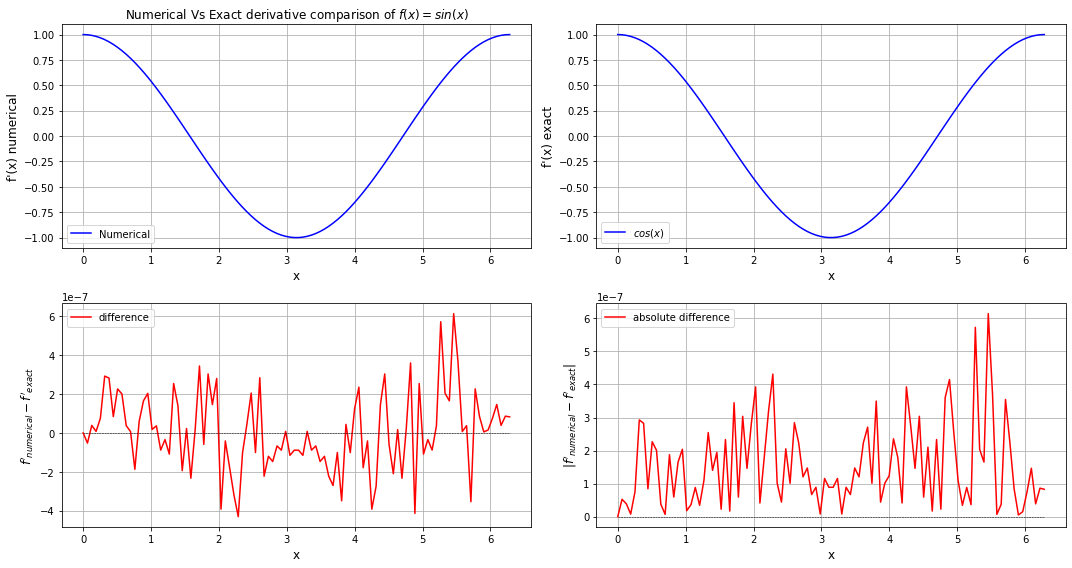

In [103]:
plot_compare(x, f_prime_numerical, f_prime_exact, f1_label="Numerical", f2_label=r"$cos(x)$", 
                 title=r"Numerical Vs Exact derivative comparison of $f(x)=sin(x)$")

In [93]:
class NumericalDerivative:
    
    def __init__(self, FinancialObject, x0, epsilon=1e-10, derivative_type="central", method="price"):
        
        self.f = getattr(FinancialObject, method)
        self.x0 = x0
        self.eps = epsilon
        self.type = derivative_type

        # deerivative type check
        if derivative_type not in ['central', 'backward', 'forward']:
            raise NotImplementedError("Derivative Type: '{}' does not exist!".format(derivative_type))
            
    def deriv(self):

        if self.type == 'backward':
            return self.__backward_deriv()
        elif self.type == 'central':
            return self.__central_deriv()
        else:
            return self.__forward_deriv()

    def __backward_deriv(self):
        return (self.f(self.x0) - self.f(self.x0 - self.eps))/(self.eps)

    def __central_deriv(self):
        return (self.f(self.x0 + self.eps) - self.f(self.x0 - self.eps))/(2*self.eps)

    def __forward_deriv(self):
        return (self.f(self.x0 + self.eps) - self.f(self.x0))/(self.eps)

In [24]:
mkt_env = MarketEnvironment()

Initializing the MarketEnvironment!


In [25]:
Vanilla_Call = PlainVanillaOption(mkt_env)

Initializing the EuropeanOption!


In [26]:
S_t = Vanilla_Call.get_S()

In [27]:
num_der = NumericalDerivative(Vanilla_Call, x0=S_t)

In [28]:
num_der.deriv()

0.36848746276518796

In [104]:
S = np.linspace(50, 150, 200)

In [106]:
num_der = NumericalDerivative(Vanilla_Call, x0=S)

In [109]:
delta_numerical = num_der.deriv()

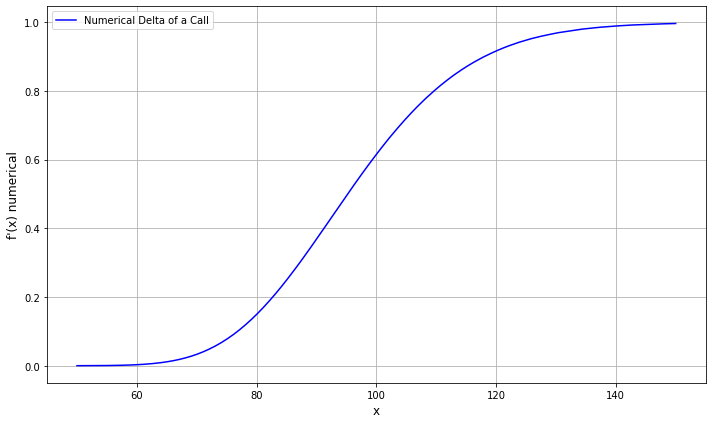

In [111]:
plot(x=S, f=delta_numerical, f_label="Numerical Delta of a Call")